# Test out standardized ADCIRC, SELFE and FVCOM  datasets with pyugrid and iris

The datasets being accessed here are NetCDF files from ADCIRC, SELFE and FVCOM, with attributes added or modified virtually using NcML to meet the [UGRID conevntions standard for unstructured grid models](https://github.com/ugrid-conventions/ugrid-conventions/blob/v0.9.0/ugrid-conventions.md). 

This example was developed for the Integrated Ocean Observing System (IOOS) Coastal and Ocean Modeling Testbed. 

You can quickly and easily [set up the IOOS Anaconda python environment that can run this notebook](https://github.com/ioos/conda-recipes/wiki).

In [1]:
%matplotlib inline

import warnings
from datetime import datetime

import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt

import iris
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import netCDF4
import pyugrid

print('pyugrid version: {}'.format(pyugrid.__version__))
print('netCDF4 version: {}'.format(netCDF4.__version__))

pyugrid version: 0.1.7
netCDF4 version: 1.2.2


## Models

In [2]:
models = dict(ADCIRC='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Rita_2D_final_run_without_waves',
              FVCOM='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/USF_FVCOM/Hurricane_Rita_2D_final_run_without_waves',
              SELFE='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves')

## Set parameters

In [3]:
bbox = [-95, -85, 27, 32]  # Set the bounding box.
variable = 'sea_surface_height_above_geoid'  # CF standard_name (or long_name, if no standard_name).
levels = np.arange(-1, 5.0, 0.2)  # Set the contour levels.
start = datetime(2005, 9, 24, 5, 0, 0)  # UTC time

## Read the data

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cube = iris.load_cube(models['ADCIRC'], variable)

print(cube)

sea_surface_height_above_geoid / (unknown) (time: 1728; -- : 417642)
     Dimension coordinates:
          time                                  x          -
     Auxiliary coordinates:
          latitude                              -          x
          longitude                             -          x
     Attributes:
          Conventions: CF-1.6, UGRID-0.9
          DODS_EXTRA.Unlimited_Dimension: time
          a00: 0.35
          agrid: grid
          b00: 0.3
          c00: 0.35
          cdm_data_type: ugrid
          cf: 0.0
          comments: None
          contact: Rick Leuttich, UNC
          convention: None
          cori: 0.0
          creation_date: 2013-01-26 15:35:41 -05:00
          description: TropUL_SURA_Rita_Tides_Winds      ! 32 CHARACTER ALPHANUMERIC RUN DESC...
          dramp: 12.0
          dt: 4.0
          eslm: 50.0
          fort.15: ==== Input File Parameters (below) ====
          grid_type: Triangular
          h0: 0.1
          history: Version 1

## Read the grid

In [5]:
ug = pyugrid.UGrid.from_ncfile(models['ADCIRC'])

## Make the matplotlib triangulation object

In [6]:
lon = ug.nodes[:, 0]
lat = ug.nodes[:, 1]
faces = ug.faces

triang = tri.Triangulation(lon, lat, triangles=faces)

## Time slice

In [7]:
time_var = cube.coord('time')
idx_time = time_var.nearest_neighbour_index(time_var.units.date2num(start))

print(idx_time)

c = cube[idx_time, ...]

893


In [8]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m', zorder=1)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

/home/filipe/miniconda3/envs/IOOS/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


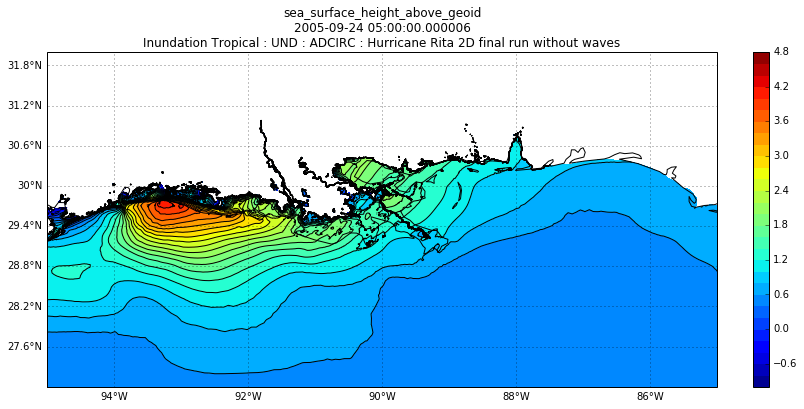

In [9]:
fig, ax = make_map()
ax.set_extent(bbox)
ax.tricontour(triang, c.data, colors='k', levels=levels)
cs = ax.tricontourf(triang, c.data, levels=levels)
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)

time_string = time_var.units.num2date(time_var.points[idx_time])
title = ax.set_title('{}\n{}\n{}'.format(variable,
                                         time_string,
                                         c.attributes['title']))

## Now let's do all the other models

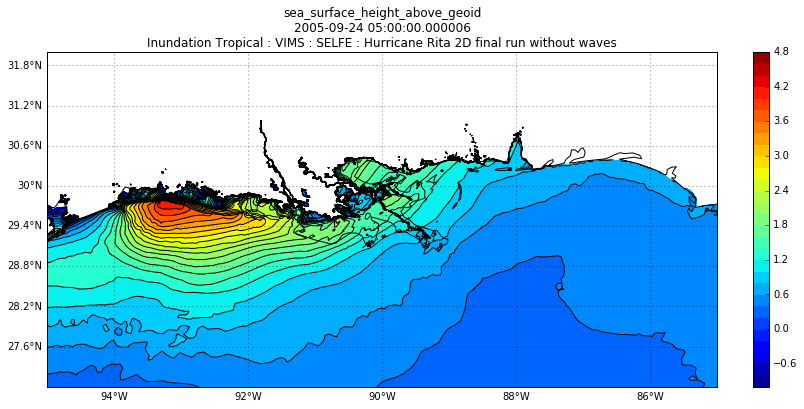

In [10]:
url = models['SELFE']

# Data.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cube = iris.load_cube(url, variable)

# Time slice.
time_var = cube.coord('time')
idx_time = time_var.nearest_neighbour_index(time_var.units.date2num(start))
c = cube[idx_time, ...]

# Grid.
ug = pyugrid.UGrid.from_ncfile(url)

# Triangulation.
lon = ug.nodes[:, 0]
lat = ug.nodes[:, 1]
faces = ug.faces
triang = tri.Triangulation(lon, lat, triangles=faces)

# Figure.
fig, ax = make_map()
ax.set_extent(bbox)
ax.tricontour(triang, c.data, colors='k', levels=levels)
cs = ax.tricontourf(triang, c.data, levels=levels)
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)

time_string = time_var.units.num2date(time_var.points[idx_time])
title = ax.set_title('{}\n{}\n{}'.format(variable,
                                         time_string,
                                         c.attributes['title']))

In [11]:
url = models['FVCOM']

# Data.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cube = iris.load_cube(url, variable)

ConstraintMismatchError: no cubes found

There is probably a bug in iris, the data is there but we cannot read it as a cube.

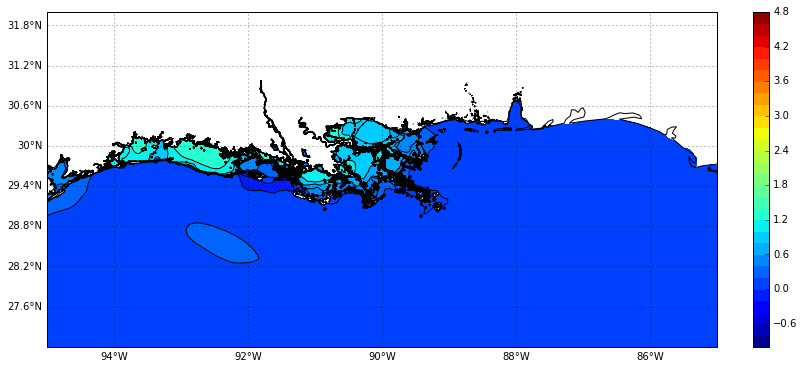

In [12]:
with netCDF4.Dataset(url) as nc:
    # Last time step only.
    ele = nc['zeta'][-1, ...]

# Grid.
ug = pyugrid.UGrid.from_ncfile(url)

# Triangulation.
lon = ug.nodes[:, 0]
lat = ug.nodes[:, 1]
faces = ug.faces
triang = tri.Triangulation(lon, lat, triangles=faces)

# Figure.
fig, ax = make_map()
ax.set_extent(bbox)
ax.tricontour(triang, ele, colors='k', levels=levels)
cs = ax.tricontourf(triang, ele, levels=levels)
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)